In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
METRICS_TDA = r"C:\Users\HP\Downloads\Tareas y actividades Tec\Experimento_2_NIXTLA\outputs\nbeatsx_cv_tdas_metrics.parquet"
METRICS_NOT_TDA = r"C:\Users\HP\Downloads\Tareas y actividades Tec\Experimento_2_NIXTLA\outputs\nbeatsx_cv_metrics.parquet"
PREDICTS_TDA= r"C:\Users\HP\Downloads\Tareas y actividades Tec\Experimento_2_NIXTLA\outputs\nbeatsx_final_forecast_TDA.parquet"
PREDICTS_NOT_TDA = r"C:\Users\HP\Downloads\Tareas y actividades Tec\Experimento_2_NIXTLA\outputs\nbeatsx_final_forecast.parquet"
TRAINING_DATA = r"C:\Users\HP\Downloads\Tareas y actividades Tec\Experimento_2_NIXTLA\data\panel_tda.parquet"

# Claves para unir métricas/predicciones
# Ajusta según tu estructura (puede ser ['unique_id'], ['unique_id', 'h'], etc.)
key_cols_metrics = ["unique_id"]
key_cols_preds = ["unique_id", "ds"]

In [3]:

# ============================================================
# 1. Carga y merge de MÉTRICAS
# ============================================================

def load_and_merge_metrics(
    path_metrics_tda: str,
    path_metrics_notda: str,
    key_cols: list,
    metric_cols: list = None,
    suffix_tda: str = "_tda",
    suffix_notda: str = "_notda"
) -> pd.DataFrame:
    """
    Carga dos parquets de métricas (con y sin TDA) y los une por key_cols.
    
    Parámetros
    ----------
    path_metrics_tda : str
        Ruta al parquet de métricas del modelo con TDA.
    path_metrics_notda : str
        Ruta al parquet de métricas del modelo sin TDA.
    key_cols : list
        Lista de columnas que identifican cada fila (ej. ['unique_id', 'h']).
    metric_cols : list, opcional
        Lista de métricas a considerar (ej. ['mape', 'rmse']).
        Si es None, se detectan como todas las columnas numéricas
        que no estén en key_cols.
    suffix_tda : str
        Sufijo para columnas de métricas del modelo con TDA.
    suffix_notda : str
        Sufijo para columnas de métricas del modelo sin TDA.
    
    Devuelve
    --------
    df_merged : pd.DataFrame
        DataFrame con métricas de ambos modelos y columnas de diferencia:
        - <metric>_diff = metric_tda - metric_notda
        - <metric>_rel  = (metric_tda - metric_notda) / metric_notda
    """
    metrics_tda = pd.read_parquet(path_metrics_tda)
    metrics_notda = pd.read_parquet(path_metrics_notda)

    # Detectar columnas de métricas si no se especifican
    if metric_cols is None:
        metric_cols_tda = [
            c for c in metrics_tda.columns
            if c not in key_cols and np.issubdtype(metrics_tda[c].dtype, np.number)
        ]
        metric_cols_notda = [
            c for c in metrics_notda.columns
            if c not in key_cols and np.issubtype(metrics_notda[c].dtype, np.number)
        ]
        metric_cols = sorted(list(set(metric_cols_tda).intersection(metric_cols_notda)))

    # Nos quedamos solo con keys + métricas
    metrics_tda = metrics_tda[key_cols + metric_cols].copy()
    metrics_notda = metrics_notda[key_cols + metric_cols].copy()

    # Añadir sufijos
    metrics_tda = metrics_tda.rename(
        columns={m: f"{m}{suffix_tda}" for m in metric_cols}
    )
    metrics_notda = metrics_notda.rename(
        columns={m: f"{m}{suffix_notda}" for m in metric_cols}
    )

    # Merge
    df_merged = metrics_tda.merge(metrics_notda, on=key_cols, how="inner")

    # Calcular diferencias
    for m in metric_cols:
        col_tda = f"{m}{suffix_tda}"
        col_notda = f"{m}{suffix_notda}"
        diff_col = f"{m}_diff"
        rel_col = f"{m}_rel"

        df_merged[diff_col] = df_merged[col_tda] - df_merged[col_notda]
        df_merged[rel_col] = df_merged[diff_col] / df_merged[col_notda]

    return df_merged



def load_and_merge_predictions_from_panel(
    path_panel: str,
    path_preds_tda: str,
    path_preds_notda: str,
    key_cols: list,
    y_col: str = "y",
    yhat_col: str = "NBEATSx",
    suffix_tda: str = "_tda",
    suffix_notda: str = "_notda"
) -> pd.DataFrame:
    """
    Carga:
      - el panel original con la columna y (valor real),
      - las predicciones con TDA,
      - las predicciones sin TDA,
    los une por key_cols y calcula errores punto a punto.

    Parámetros
    ----------
    path_panel : str
        Ruta al parquet del panel original (debe contener key_cols + y_col).
    path_preds_tda : str
        Ruta al parquet de predicciones del modelo con TDA
        (debe contener key_cols + yhat_col).
    path_preds_notda : str
        Ruta al parquet de predicciones del modelo sin TDA
        (debe contener key_cols + yhat_col).
    key_cols : list
        Columnas clave para identificar cada observación
        (ej. ['unique_id', 'ds']).
    y_col : str
        Nombre de la columna con el valor real en el panel.
    yhat_col : str
        Nombre de la columna con la predicción en los parquets de predicción
        (en tu caso: 'NBEATSx').
    suffix_tda : str
        Sufijo para predicciones/errores del modelo con TDA.
    suffix_notda : str
        Sufijo para predicciones/errores del modelo sin TDA.

    Devuelve
    --------
    df : pd.DataFrame
        DataFrame con:
        - key_cols
        - y (valor real)
        - y_hat_tda, y_hat_notda
        - e_tda, e_notda
        - ae_tda, ae_notda
        - delta_ae = ae_tda - ae_notda
    """
    # 1) Cargar panel y quedarnos con keys + y
    panel = pd.read_parquet(path_panel)
    panel = panel[key_cols + [y_col]].copy()

    # 2) Cargar predicciones con TDA
    preds_tda = pd.read_parquet(path_preds_tda)
    preds_tda = preds_tda[key_cols + [yhat_col]].copy()
    preds_tda = preds_tda.rename(columns={yhat_col: f"{yhat_col}{suffix_tda}"})

    # 3) Cargar predicciones sin TDA
    preds_notda = pd.read_parquet(path_preds_notda)
    preds_notda = preds_notda[key_cols + [yhat_col]].copy()
    preds_notda = preds_notda.rename(columns={yhat_col: f"{yhat_col}{suffix_notda}"})

    # 4) Merge: panel + preds_tda + preds_notda
    df = panel.merge(preds_tda, on=key_cols, how="inner")
    df = df.merge(preds_notda, on=key_cols, how="inner")

    # 5) Crear columnas de errores
    yhat_tda_col = f"{yhat_col}{suffix_tda}"       # 'NBEATSx_tda'
    yhat_notda_col = f"{yhat_col}{suffix_notda}"   # 'NBEATSx_notda'

    df["e_tda"] = df[y_col] - df[yhat_tda_col]
    df["e_notda"] = df[y_col] - df[yhat_notda_col]

    df["ae_tda"] = df["e_tda"].abs()
    df["ae_notda"] = df["e_notda"].abs()

    df["delta_ae"] = df["ae_tda"] - df["ae_notda"]

    # Opcional: renombrar a nombres más genéricos para usar en otras funciones
    df = df.rename(
        columns={
            yhat_tda_col: "y_hat_tda",
            yhat_notda_col: "y_hat_notda"
        }
    )

    return df

def compute_global_metrics_summary(
    df_metrics: pd.DataFrame,
    metric_cols: list,
    suffix_tda: str = "_tda",
    suffix_notda: str = "_notda"
) -> pd.DataFrame:
    """
    A partir de df_metrics (merge de métricas) calcula una tabla global
    que resume cada métrica con y sin TDA, su diferencia absoluta y relativa.

    La agregación es la media sobre las filas (ej., media sobre activos).
    """
    rows = []

    for m in metric_cols:
        col_tda = f"{m}{suffix_tda}"
        col_notda = f"{m}{suffix_notda}"

        mean_tda = df_metrics[col_tda].mean()
        mean_notda = df_metrics[col_notda].mean()
        diff_abs = mean_tda - mean_notda
        diff_rel = diff_abs / mean_notda if mean_notda != 0 else np.nan

        rows.append({
            "metric": m,
            "value_notda": mean_notda,
            "value_tda": mean_tda,
            "diff_abs": diff_abs,
            "diff_rel_pct": diff_rel * 100.0
        })

    df_global = pd.DataFrame(rows)
    return df_global


def save_global_metrics_latex(
    df_global: pd.DataFrame,
    path_tex: str
) -> None:
    """
    Guarda df_global como tabla LaTeX lista para \\input{}.

    Columnas se renombran a algo más legible.
    """
    df_to = df_global.rename(columns={
        "metric": "Métrica",
        "value_notda": "Sin TDA",
        "value_tda": "Con TDA",
        "diff_abs": "Dif. abs.",
        "diff_rel_pct": "Dif. rel. (\\%)"
    })

    latex_str = df_to.to_latex(
        index=False,
        float_format="%.4f",
        escape=False  # para que el % salga bien
    )

    import os
    os.makedirs(os.path.dirname(path_tex), exist_ok=True)
    with open(path_tex, "w", encoding="utf-8") as f:
        f.write(latex_str)




In [4]:
def save_pointwise_summary_latex(
    summary_df: pd.DataFrame,
    path_tex: str,
    rename_group_col: str = None
) -> None:
    """
    Guarda un resumen de errores punto a punto como tabla LaTeX.

    Parameters
    ----------
    summary_df : pd.DataFrame
        Resultado de summarize_pointwise_errors.
    path_tex : str
        Ruta del .tex donde se guardará la tabla.
    rename_group_col : str, opcional
        Nombre más legible para la primera columna de agrupación
        (ej. 'Activo' en lugar de 'unique_id').
    """
    df_to = summary_df.copy()

    # Renombrar col de grupo si se desea
    if rename_group_col is not None and len(df_to.columns) > 0:
        first_col = df_to.columns[0]
        df_to = df_to.rename(columns={first_col: rename_group_col})

    df_to = df_to.rename(columns={
        "n_obs": "N",
        "prop_tda_mejor": "Prop. TDA mejor",
        "prop_notda_mejor": "Prop. sin TDA mejor",
        "delta_ae_mean": "Media $\\Delta |e|$",
        "delta_ae_median": "Mediana $\\Delta |e|$"
    })

    latex_str = df_to.to_latex(
        index=False,
        float_format="%.4f"
    )

    import os
    os.makedirs(os.path.dirname(path_tex), exist_ok=True)
    with open(path_tex, "w", encoding="utf-8") as f:
        f.write(latex_str)



def compute_directional_accuracy(
    df: pd.DataFrame,
    y_col: str = "y",
    yhat_tda_col: str = "y_hat_tda",
    yhat_notda_col: str = "y_hat_notda",
    group_cols: list = None
) -> pd.DataFrame:
    """
    Calcula la "directional accuracy" (acierto de signo) para cada modelo.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame devuelto por load_and_merge_predictions.
    y_col : str
        Columna con el valor real (puede ser retorno).
    yhat_tda_col : str
        Columna con la predicción del modelo con TDA.
    yhat_notda_col : str
        Columna con la predicción del modelo sin TDA.
    group_cols : list, opcional
        Columnas por las que agrupar (ej. ['unique_id']).
        Si es None, se hace resumen global.
    
    Devuelve
    --------
    da : pd.DataFrame
        Tabla con directional accuracy de ambos modelos y casos de desacuerdo.
    """
    if group_cols is None:
        group_cols = []

    df_da = df.copy()

    df_da["sign_y"] = np.sign(df_da[y_col])
    df_da["sign_tda"] = np.sign(df_da[yhat_tda_col])
    df_da["sign_notda"] = np.sign(df_da[yhat_notda_col])

    df_da["acierto_tda"] = (df_da["sign_y"] == df_da["sign_tda"]).astype(int)
    df_da["acierto_notda"] = (df_da["sign_y"] == df_da["sign_notda"]).astype(int)

    df_da["tda_correct_notda_wrong"] = (
        (df_da["acierto_tda"] == 1) & (df_da["acierto_notda"] == 0)
    ).astype(int)

    df_da["notda_correct_tda_wrong"] = (
        (df_da["acierto_tda"] == 0) & (df_da["acierto_notda"] == 1)
    ).astype(int)

    if len(group_cols) == 0:
        df_da["_group"] = "GLOBAL"
        group_cols_internal = ["_group"]
    else:
        group_cols_internal = group_cols

    da = df_da.groupby(group_cols_internal).agg(
        n_obs=("sign_y", "size"),
        da_tda=("acierto_tda", "mean"),
        da_notda=("acierto_notda", "mean"),
        tda_correct_notda_wrong=("tda_correct_notda_wrong", "mean"),
        notda_correct_tda_wrong=("notda_correct_tda_wrong", "mean")
    ).reset_index()

    if "_group" in da.columns:
        da = da.drop(columns=["_group"])

    return da

In [5]:

# ============================================================
# 4. Gráfico: y real vs predicciones con/sin TDA
# ============================================================

def plot_predictions_vs_real(
    df: pd.DataFrame,
    unique_id: str = None,
    unique_id_col: str = "unique_id",
    ds_col: str = "ds",
    y_col: str = "y",
    yhat_tda_col: str = "y_hat_tda",
    yhat_notda_col: str = "y_hat_notda",
    start_date: str = None,
    end_date: str = None,
    max_points: int = 500,
    title: str = None,
    figsize: tuple = (12, 5)
) -> None:
    """
    Grafica valores reales vs predicciones con y sin TDA para un activo
    (o para todo el panel si unique_id es None).
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame devuelto por load_and_merge_predictions.
    unique_id : str, opcional
        Id del activo a graficar. Si es None, se usa todo el df.
    unique_id_col : str
        Columna que identifica el activo.
    ds_col : str
        Columna con la fecha (se intentará convertir a datetime).
    y_col : str
        Columna con el valor real.
    yhat_tda_col : str
        Columna con la predicción del modelo con TDA.
    yhat_notda_col : str
        Columna con la predicción del modelo sin TDA.
    start_date : str, opcional
        Fecha mínima (ej. '2022-01-01') para recortar el gráfico.
    end_date : str, opcional
        Fecha máxima.
    max_points : int
        Máximo de puntos a graficar (para no saturar la figura).
        Si hay más, se hace un muestreo uniforme.
    title : str, opcional
        Título del gráfico. Si es None, se construye automáticamente.
    figsize : tuple
        Tamaño de la figura.
    """
    df_plot = df.copy()

    # Filtrar por unique_id si se especifica
    if unique_id is not None and unique_id_col in df_plot.columns:
        df_plot = df_plot[df_plot[unique_id_col] == unique_id].copy()

    # Convertir fecha a datetime si aún no lo es
    if not np.issubdtype(df_plot[ds_col].dtype, np.datetime64):
        df_plot[ds_col] = pd.to_datetime(df_plot[ds_col])

    # Filtrar por rango de fechas
    if start_date is not None:
        df_plot = df_plot[df_plot[ds_col] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_plot = df_plot[df_plot[ds_col] <= pd.to_datetime(end_date)]

    # Ordenar
    df_plot = df_plot.sort_values(ds_col)

    # Submuestreo si hay demasiados puntos
    n = len(df_plot)
    if n > max_points and max_points > 0:
        idx = np.linspace(0, n - 1, max_points).astype(int)
        df_plot = df_plot.iloc[idx]

    # Construir título por defecto
    if title is None:
        if unique_id is not None:
            title = f"Real vs predicciones con/sin TDA - {unique_id}"
        else:
            title = "Real vs predicciones con/sin TDA"

    plt.figure(figsize=figsize)
    plt.plot(df_plot[ds_col], df_plot[y_col], label="Real", linewidth=2)
    plt.plot(df_plot[ds_col], df_plot[yhat_tda_col], label="Predicción con TDA", linestyle="--")
    plt.plot(df_plot[ds_col], df_plot[yhat_notda_col], label="Predicción sin TDA", linestyle=":")
    plt.xlabel("Fecha")
    plt.ylabel(y_col)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [6]:
def plot_delta_ae_histogram(
    df: pd.DataFrame,
    nbins: int = 50,
    figsize: tuple = (6, 4),
    path_fig: str = None
) -> None:
    """
    Dibuja un histograma de delta_ae (ae_tda - ae_notda).

    Si path_fig no es None, guarda la figura en disco (pdf/png ...).
    """
    plt.figure(figsize=figsize)
    plt.hist(df["delta_ae"].dropna(), bins=nbins)
    plt.xlabel(r"$\Delta |e| = |e_{\mathrm{TDA}}| - |e_{\mathrm{no\ TDA}}|$")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de la diferencia de error absoluto")
    plt.tight_layout()

    if path_fig is not None:
        import os
        os.makedirs(os.path.dirname(path_fig), exist_ok=True)
        plt.savefig(path_fig, bbox_inches="tight")

    # Si estás en notebook puedes usar plt.show(); en script puro lo puedes omitir.
    # plt.show()


In [7]:
def summarize_pointwise_errors(
    df: pd.DataFrame,
    group_cols: list = None
) -> pd.DataFrame:
    """
    Calcula resúmenes básicos del desempeño comparando ae_tda vs ae_notda.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame devuelto por load_and_merge_predictions_from_panel.
    group_cols : list, opcional
        Columnas por las que agrupar (ej. ['unique_id'] o ['unique_id', 'h']).
        Si es None, se hace resumen global.
    
    Devuelve
    --------
    summary : pd.DataFrame
        Tabla con:
        - n_obs
        - prop_tda_mejor (delta_ae < 0)
        - prop_notda_mejor (delta_ae > 0)
        - delta_ae_mean
        - delta_ae_median
    """
    if group_cols is None:
        group_cols = []

    if len(group_cols) == 0:
        # Para facilitar, creamos una columna dummy
        df_tmp = df.copy()
        df_tmp["_group"] = "GLOBAL"
        group_cols_internal = ["_group"]
    else:
        df_tmp = df
        group_cols_internal = group_cols

    def _agg(group):
        n_obs = len(group)
        prop_tda_mejor = (group["delta_ae"] < 0).mean()
        prop_notda_mejor = (group["delta_ae"] > 0).mean()
        return pd.Series({
            "n_obs": n_obs,
            "prop_tda_mejor": prop_tda_mejor,
            "prop_notda_mejor": prop_notda_mejor,
            "delta_ae_mean": group["delta_ae"].mean(),
            "delta_ae_median": group["delta_ae"].median()
        })

    summary = df_tmp.groupby(group_cols_internal).apply(_agg).reset_index()

    if "_group" in summary.columns:
        summary = summary.drop(columns=["_group"])

    return summary


C:\Users\HP\AppData\Local\Temp\ipykernel_3020\3726015953.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_tmp.groupby(group_cols_internal).apply(_agg).reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_3020\3726015953.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_tmp.groupby(group_cols_internal).apply(_agg).reset_index()


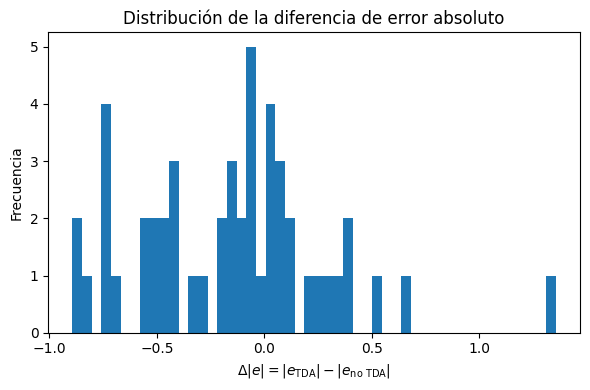

In [8]:

# --- 1. Métricas ---
metrics_merged = load_and_merge_metrics(
    path_metrics_tda=METRICS_TDA,
    path_metrics_notda=METRICS_NOT_TDA,
    key_cols=key_cols_metrics,
    metric_cols=["MAPE","MAE" ,"MASE","RMSE"]  # ajusta a las métricas que tengas
)
# metrics_merged.to_parquet("outputs/metrics_comparadas.parquet")

# --- 2. Predicciones ---
preds_merged = load_and_merge_predictions_from_panel(
    path_panel=TRAINING_DATA,                # panel original con y
    path_preds_tda=PREDICTS_TDA,
    path_preds_notda=PREDICTS_NOT_TDA,
    key_cols=["unique_id", "ds"],                   # las llaves que están en los 3 archivos
    y_col="y",                                      # así se llama tu target en el panel
    yhat_col="NBEATSx"                              # así se llama tu predicción
)


# Renombrar columnas de predicción para usarlas en funciones posteriores
preds_merged = preds_merged.rename(
    columns={
        "y_hat_tda": "y_hat_tda",         # ya viene así por defecto
        "y_hat_notda": "y_hat_notda"     # ya viene así por defecto
    }
)


# --- 4. Directional accuracy global ---
da_global = compute_directional_accuracy(
    preds_merged,
    y_col="y",
    yhat_tda_col="y_hat_tda",
    yhat_notda_col="y_hat_notda",
    group_cols=None
)
# da_global.to_parquet("outputs/directional_accuracy_global.parquet")

# 2) Resumen global (para Tabla "pointwise_global")
# summary_global = summarize_pointwise_errors(preds_merged, group_cols=None)
# save_pointwise_summary_latex(
#     summary_global,
#     path_tex="results/pointwise_summary_global.tex"
# )

# # 3) Resumen por activo (para Tabla "pointwise_by_asset")
# summary_by_asset = summarize_pointwise_errors(preds_merged, group_cols=["unique_id"])
# save_pointwise_summary_latex(
#     summary_by_asset,
#     path_tex="results/pointwise_summary_by_asset.tex",
#     rename_group_col="Activo"
# )


summary_global = summarize_pointwise_errors(preds_merged, group_cols=None)
save_pointwise_summary_latex(
    summary_global,
    path_tex="results/pointwise_summary_global.tex"
)

# 3) Resumen por activo (para Tabla "pointwise_by_asset")
summary_by_asset = summarize_pointwise_errors(preds_merged, group_cols=["unique_id"])
save_pointwise_summary_latex(
    summary_by_asset,
    path_tex="results/pointwise_summary_by_asset.tex",
    rename_group_col="Activo"
)


# # --- 5. Gráfico para un activo específico ---
# # Cambia 'AAPL' por el unique_id que quieras inspeccionar
# plot_predictions_vs_real(
#     preds_merged,
#     unique_id="AAPL",
#     unique_id_col="unique_id",
#     ds_col="ds",
#     y_col="y",
#     yhat_tda_col="y_hat_tda",
#     yhat_notda_col="y_hat_notda",
#     start_date=None,
#     end_date=None,
#     max_points=300
# )

plot_delta_ae_histogram(
    preds_merged,
    nbins=50,
    path_fig="results/delta_ae_hist.pdf"
)

